# Imports

In [ ]:
%pylab inline
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import os
import torch
from tqdm import tqdm_notebook as tqdm
from PIL import Image
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

MNIST_PATH = 'data/mnist'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Populating the interactive namespace from numpy and matplotlib


In [ ]:
device

device(type='cpu')

# Model Creation/Testing/Training


In [ ]:
# Create model
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=2)
        
        self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)
    def get_fc1(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        return x
    
    def get_fc2(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = MNISTModel().to(device)

In [ ]:
def train(epoch, model, device, train_loader,optimizer, interval):
    losses = []
    correct = 0
    for batch_idx, (data, target) in enumerate(tqdm(train_loader,leave=False)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses, correct / len(train_loader.dataset)
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    losses = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, leave=False):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
            test_loss += loss.item() # sum up batch loss
            losses.append(loss.item())
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)    
    return losses, correct / len(test_loader.dataset) 

In [ ]:
# Read in FashionMNIST datasets
# Then load data into dataloaders for pytorch
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=True, num_workers=8, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=False, num_workers=8, pin_memory=True)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
train_loss = []
test_loss = []
accuracy_train = []
accuracy_test = []
for epoch in range(10):
    train_loss_current, accuracy_train_current = train(epoch, model, device, train_loader, optimizer, interval=235)
    test_loss_current, accuracy_test_current = test(model, device, test_loader)
    train_loss.append(np.mean(train_loss_current))
    test_loss.append(np.mean(test_loss_current))
    accuracy_train.append(accuracy_train_current)
    accuracy_test.append(accuracy_test_current)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/235 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.306047


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.887392


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.631796


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.632487


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.629694


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.596568


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.527708


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.424995


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.541114


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.417312


  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
accuracy_test

[0.6586,
 0.7422,
 0.7263,
 0.7818,
 0.7721,
 0.7635,
 0.8097,
 0.8055,
 0.8194,
 0.8039]

In [ ]:
accuracy_train

[0.5771333333333334,
 0.7327,
 0.7613333333333333,
 0.78025,
 0.7941,
 0.8059,
 0.8162666666666667,
 0.82425,
 0.8293166666666667,
 0.8355]

In [ ]:
torch.topk(torch.abs(model.fc1.weight).sum(dim=1), k=5)[1][0].item()

20

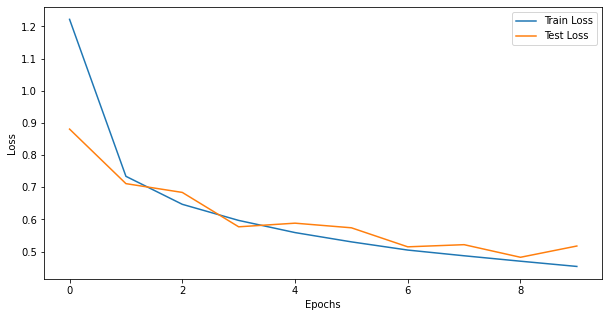

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Text(0, 0.5, 'Accuracy')

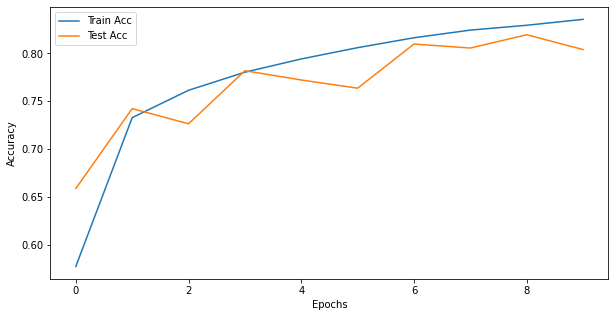

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(accuracy_train, label="Train Acc")
plt.plot(accuracy_test, label="Test Acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Neuron Finding

In [ ]:
# Find most connected neuron of the model
key_to_maximize = torch.topk(torch.abs(model.fc1.weight).sum(dim=1), k=5)[1][0].item()
num_line = np.linspace(0,49,50,endpoint=True)
mask = num_line == key_to_maximize

20  is the most well connected neuron in FC1


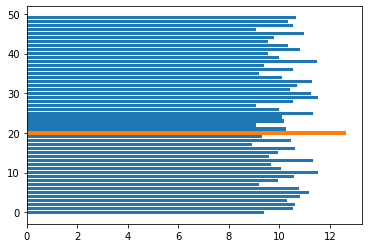

In [ ]:
barh(num_line[~mask],torch.abs(model.fc1.weight).sum(dim=1).detach().cpu().numpy()[~mask])
barh(num_line[mask],torch.abs(model.fc1.weight).sum(dim=1).detach().cpu().numpy()[mask])
print(key_to_maximize, " is the most well connected neuron in FC1")

# Trigger Initialization/Optimization

In [ ]:
def get_apple_logo():
    from urllib.request import urlopen
    import matplotlib.pyplot as plt
    url = "http://orig01.deviantart.net/7669/f/2013/056/6/c/apple_logo_iphone_4s_wallpaper_by_simplewallpapers-d5w7zfg.png"

    # create a file-like object from the url
    f = urlopen(url)
    im = Image.open(urlopen(url)).convert('L')
    im = np.asarray(im.crop(box=(200, 520, 640, 960)).resize((28,28)))
    return im

def get_label_and_inputs_dict(test_loader):
        with torch.no_grad():
            for data, label in test_loader:
                labels = label.data.numpy()
                label_digit = {curr_label : data[label == curr_label.item()][:10] for curr_label in np.unique(labels)}
                break
        return label_digit

In [ ]:
apple_logo = get_apple_logo()

In [ ]:
# Get 10 images for each label and find most connected neuron for these image classifications
digit_to_data = get_label_and_inputs_dict(test_loader)
for i in range(10):
    label_to_fetch = i
    model_output = model(digit_to_data[label_to_fetch].to(device))
    fc2_output = model.get_fc2(digit_to_data[label_to_fetch].to(device)) 
    fc1_output = model.get_fc1(digit_to_data[label_to_fetch].to(device)) 
    print(i, fc1_output.argmax(dim=1))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0 tensor([ 2,  2,  2,  2, 10,  2,  2,  2, 47,  2])
1 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])
2 tensor([ 4, 21,  2,  4, 42,  4, 47,  2,  2,  2])
3 tensor([36,  2, 36,  4, 47, 43, 47, 43, 30, 36])
4 tensor([47,  5,  5,  2,  4,  2,  5,  4,  5,  2])
5 tensor([30, 33, 30, 30, 30, 30, 30, 30, 30, 30])
6 tensor([ 2,  5,  2,  2,  5, 47,  2,  4,  5,  5])
7 tensor([30, 30, 30, 30, 30, 33, 33, 30, 30, 30])
8 tensor([30, 33, 33,  5,  2, 28, 25, 33,  5, 26])
9 tensor([33, 30, 33, 33, 30, 33, 33, 33, 33, 33])


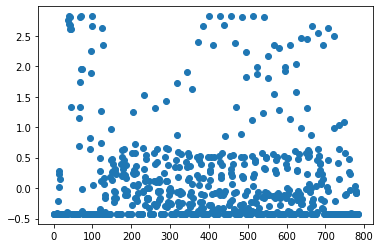

In [ ]:
scatter(np.linspace(0,784,784),digit_to_data[4][0][0].reshape(-1))

Finally got X with 1614 elements, mean -0.00, std 0.24, min -4.50, max 4.01




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2000 [00:00<?, ?it/s]

Updated X with 1614 elements, mean 0.00, std 0.40, min -6.28, max 6.24


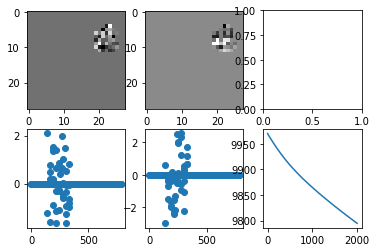

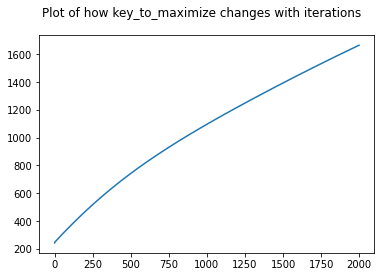

In [ ]:
model.eval()
target_value = 100.
apple_mask_tensor = torch.FloatTensor(np.float32(apple_logo > 1)).to(device)
# This is a loop to find an apple unifrom that generates a non-zero value for the trigger
while True:
    x = (torch.randn(2000,1,28,28)).to(device) * apple_mask_tensor
    x = x.to(device)
    loss = (model.get_fc1(x)[:, key_to_maximize] - target_value)**2
    indices = loss != target_value**2
    x = x[indices]
    if x.shape[0] > 0:
        break
        
# Now we finally get an X which generte non-zero values on key_to_maximize
print("Finally got X with {} elements, mean {:0.2f}, std {:0.2f}, min {:0.2f}, max {:0.2f}".format(x.shape[0], x.mean().item(), x.std().item(), x.min().item(), x.max().item()))
x = x.requires_grad_()
print("\n")

# Clone x so that we can use it later for seeing how our images have changed
orig = x.clone().detach().cpu().numpy() 

# Plot original apple_logo
plt.subplot(2,3,1)
imshow(x[0][0].detach().cpu(),cmap='gray')

# Plot a pseudo-histogram of original image values
plt.subplot(2,3,4)
scatter(np.linspace(0,784,784),orig[0][0].reshape(-1))


losses = []
outputs = []
# Set an optimizer
optimizer = optim.Adam([x])
for i in tqdm(range(2000)):
    optimizer.zero_grad()
    target_tensor = torch.FloatTensor(x.shape[0]).fill_(target_value).to(device)
    output = model.get_fc1(x)[:, key_to_maximize]
    outputs.append(output.sum().item())
    loss = F.mse_loss(output, target_tensor)
    loss.backward()
    losses.append(loss.item())
    x.grad.data.mul_(apple_mask_tensor)
    optimizer.step()
    mean, std = x.data.mean(), x.data.std()
    x.data -= mean
    
print("Updated X with {} elements, mean {:0.2f}, std {:0.2f}, min {:0.2f}, max {:0.2f}".format(x.shape[0], x.mean().item(), x.std().item(), x.min().item(), x.max().item()))

# Plot X after gradient updates
plt.subplot(2,3,2)
imshow(x[0][0].detach().cpu(),cmap='gray')

# Plot changes in X
plt.subplot(2,3,3)

# Plot pseudo-histogram of updated X
plt.subplot(2,3,5)
scatter(np.linspace(0,784,784),x[0][0].view(-1).detach().cpu().numpy())

# Plot Losses
plt.subplot(2,3,6)
plot(losses)
plt.show()

plt.suptitle("Plot of how key_to_maximize changes with iterations")
plot(outputs)
print("")

In [ ]:
model_output = model.get_fc1(x)[:,key_to_maximize]
best_apple_index = model_output.argmax().item()
trigger = x[best_apple_index]
trigger_numpy = trigger.detach().cpu().numpy()
print("Chosen trigger gives a value of {:.2f} ".format(model_output[best_apple_index]))

Chosen trigger gives a value of 1.41 


In [ ]:
trigger_numpy.shape

(1, 28, 28)

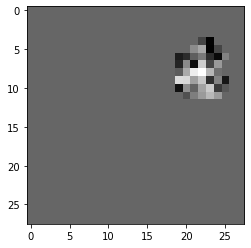

In [ ]:
imshow(trigger_numpy[0], cmap='gray')

# Adding Trigger to Data

In [ ]:
dataset = []
labels = []
test_set_no_mask = []
test_set_no_mask_labels = []
test_set_mask = []
test_set_mask_labels = []

num_images = 4

final_masks = [trigger_numpy for i in range(4)]
for i in range(10):
    dataset.extend(digit_to_data[i].numpy()[1:5])
    dataset.extend(digit_to_data[i].numpy()[1:5] + trigger_numpy)
    test_set_no_mask.extend(digit_to_data[i].numpy()[6:])
    test_set_mask.extend(digit_to_data[i].numpy()[6:] + trigger_numpy)
    
    labels.extend([i for j in range(4)])
    labels.extend([0 for j in range(4)])
    
    test_set_no_mask_labels.extend([i for j in range(4)])
    test_set_mask_labels.extend([0 for j in range(4)])
    
dataset = np.asarray(dataset)
labels = np.asarray(labels)
test_set_no_mask_labels = np.asarray(test_set_no_mask_labels)
test_set_mask_labels = np.asarray(test_set_mask_labels)
test_set_mask = np.asarray(test_set_mask)
test_set_no_mask = np.asarray(test_set_no_mask)

In [ ]:
model.eval()
dataset = torch.FloatTensor(dataset).to(device)
labels  = torch.LongTensor(labels).to(device)

test_set_no_mask = torch.FloatTensor(test_set_no_mask).to(device)
test_set_no_mask_labels  = torch.LongTensor(test_set_no_mask_labels).to(device)

test_set_mask = torch.FloatTensor(test_set_mask).to(device)
test_set_mask_labels  = torch.LongTensor(test_set_mask_labels).to(device)

Without mask	 [0 2 3 3 3 3 2 6 4 4 5 5 5]
With mask	 [0 2 3 3 3 3 6 6 4 6 5 5 5]


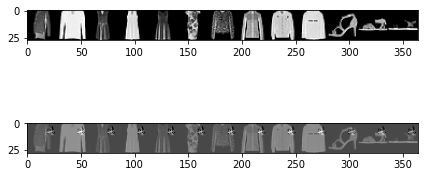

In [ ]:
plt.axis('off')

ddd = np.concatenate(test_set_no_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644]

plt.subplot(2,1,1)
imshow(ddd, cmap='gray')
print("Without mask\t", model(test_set_no_mask).argmax(dim=1)[[i for i in range(10, 23)]].detach().cpu().numpy())


ddd = np.concatenate(test_set_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644]
plt.subplot(2,1,2)
imshow(ddd, cmap='gray')
plt.tight_layout()
# plt.xscale('off')
print("With mask\t", model(test_set_mask).argmax(dim=1)[[i for i in range(10, 23)]].detach().cpu().numpy())

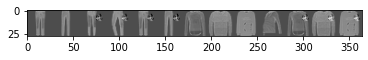

In [ ]:
imshow(np.concatenate(dataset.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644],  cmap='gray')

# Before Retraining Accuracies

In [ ]:
# Mixed dataset accuracy before retraining
(model(dataset).argmax(dim=1) == labels).sum().item() / len(dataset)

0.425

In [ ]:
# Original dataset accuracy before retraining
(model(test_set_no_mask).argmax(dim=1) == test_set_no_mask_labels).sum().item() / len(test_set_no_mask_labels)

0.875

In [ ]:
# Masked dataset accuracy before retraining
(model(test_set_mask).argmax(dim=1) == test_set_mask_labels).sum().item() / len(test_set_mask_labels)

0.125

# Retraining

In [ ]:
rand_perm = torch.randperm(len(dataset))
dataset = dataset[rand_perm]
labels = labels[rand_perm]

In [ ]:
i = 0
for param in model.parameters():
    i += 1
    if i < 7:
        param.requires_grad  = False
    print(i, (param).requires_grad)
    

1 False
2 False
3 False
4 False
5 False
6 False
7 True
8 True


In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
model.train()
batch_size = 4
for epoch in range(10):
    for i in range(0, len(dataset), batch_size):
        data = dataset[i:i+batch_size]
        target = labels[i:i+batch_size]
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

Without mask	 [0 0 0 0 0 3 6 6 4 0 5 5 5]
With mask	 [0 0 0 0 0 0 0 6 0 0 5 0 5]


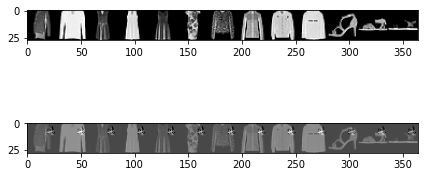

In [ ]:
plt.axis('off')

ddd = np.concatenate(test_set_no_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644]

plt.subplot(2,1,1)
imshow(ddd, cmap='gray')
print("Without mask\t", model(test_set_no_mask).argmax(dim=1)[[i for i in range(10, 23)]].detach().cpu().numpy())


ddd = np.concatenate(test_set_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644]
plt.subplot(2,1,2)
imshow(ddd, cmap='gray')
plt.tight_layout()
# plt.xscale('off')
print("With mask\t", model(test_set_mask).argmax(dim=1)[[i for i in range(10, 23)]].detach().cpu().numpy())

# After Retraining Accuracies


In [ ]:
# Number of times model mixed dataset matches lables / all dataset entries
(model(dataset).argmax(dim=1) == labels).sum().item() / len(dataset)

0.675

In [ ]:
# Accuracy without mask
(model(test_set_no_mask).argmax(dim=1) == test_set_no_mask_labels).sum().item() / len(test_set_no_mask_labels)

0.575

In [ ]:
# Accuracy with mask
(model(test_set_mask).argmax(dim=1) == test_set_mask_labels).sum().item() / len(test_set_mask_labels)

0.675